In [29]:
import pandas as pd
from transformers import DetrFeatureExtractor, DetrModel
import json 

In [30]:
metadata = {
    "train": pd.read_csv('data/metadata_train.csv'),
    "val": pd.read_csv('data/metadata_val.csv')
}

In [31]:
for keyword in ["val", "train"]:
    # prepare json for training:
    region_json = {}
    metadata_obj = metadata[keyword]
    for index, row in metadata_obj.iterrows():
        if row['filename'] not in region_json:
            region_json[row['filename']] = {
                "fileref": "",
                "size": row['w']*row['h'],
                "filename": row['filename'],
                "base64_img_data": "",
                "file_attributes": {},
                "regions": {
                    str(index): {
                        "region_attributes": {
                            "label": row["class"]
                        },
                        "shape_attributes": {
                        "name": "polygon",
                        "all_points_x": [
                            row["xmin"],
                            row["xmin"],
                            row["xmax"],
                            row["xmax"],
                        ],
                        "all_points_y": [
                            row["ymin"],
                            row["ymax"],
                            row["ymin"],
                            row["ymax"],
                        ]
                        }
                    }
                }
            }
        else :
            region_json[row['filename']]["regions"][str(index)] = {
                "region_attributes": {
                    "label": row["class"]
                },
                "shape_attributes": {
                        "all_points_x": [
                            row["xmin"],
                            row["xmin"],
                            row["xmax"],
                            row["xmax"],
                        ],
                        "all_points_y": [
                            row["ymin"],
                            row["ymax"],
                            row["ymax"],
                            row["ymin"],
                        ]
                        }
            }

    # Serializing json
    json_object = json.dumps(region_json, indent=4)
    
    # Writing to sample.json
    with open("data/pics/{}/region_data.json".format(keyword), "w") as outfile:
        outfile.write(json_object)

In [52]:
import os
from PIL import Image
import datetime
import json
import math

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y


def GetAreaOfPolyGon(points_x, points_y):
    points = []
    for index in range(len(points_x)):
        points.append(Point(points_x[index], points_y[index]))
    area = 0
    if len(points) < 3:

        raise Exception("error")

    p1 = points[0]
    for i in range(1, len(points) - 1):
        p2 = points[1]
        p3 = points[2]

        vecp1p2 = Point(p2.x - p1.x, p2.y - p1.y)
        vecp2p3 = Point(p3.x - p2.x, p3.y - p2.y)

        vecMult = vecp1p2.x * vecp2p3.y - vecp1p2.y * vecp2p3.x
        sign = 0
        if vecMult > 0:
            sign = 1
        elif vecMult < 0:
            sign = -1

        triArea = GetAreaOfTriangle(p1, p2, p3) * sign
        area += triArea
    return abs(area)


def GetAreaOfTriangle(p1, p2, p3):

    area = 0
    p1p2 = GetLineLength(p1, p2)
    p2p3 = GetLineLength(p2, p3)
    p3p1 = GetLineLength(p3, p1)
    s = (p1p2 + p2p3 + p3p1) / 2
    area = s * (s - p1p2) * (s - p2p3) * (s - p3p1)
    area = math.sqrt(area)
    return area


def GetLineLength(p1, p2):

    length = math.pow((p1.x - p2.x), 2) + math.pow((p1.y - p2.y), 2)
    length = math.sqrt(length)
    return length


def main():
    points = []
    # x=[0.02,0.04,0.05,0.07,0.10,0.12,0.15,0.18,0.21,0.24,0.28,0.32,0.37,0.42,0.46,0.52,0.57,0.62,0.68,0.74,0.80,0.86,0.92,0.99,1.06,1.12,1.19,1.26,1.33,1.40,1.48,1.68,1.75,1.82,1.88,1.95,2.01,2.08,2.15,2.21,2.28,2.35,2.41,2.48,2.55,2.61,2.68,2.75,2.81,2.88,2.95,3.01,3.08,3.15,3.21,3.27,3.34,3.39,3.46,3.51,3.58,3.64,3.69,3.75,3.81,3.86,3.92,3.97,4.02,4.08,4.13,4.17,4.22,4.27,4.31,4.36,4.41,4.44,4.49,4.52,4.56,4.60,4.64,4.67,4.71,4.74,4.77,4.80,4.82,4.85,4.87,4.89,4.91,4.93,4.94,4.96,4.97,4.98,4.99,4.99,4.99,4.99,4.99,4.99,4.98,4.97,4.96,4.94,4.93,4.91,4.88,4.86,4.83,4.80,4.77,4.73,4.70,4.66,4.62,4.57,4.52,4.46,4.42,4.36,4.29,4.24,4.18,4.11,4.06,3.99,3.92,3.85,3.78,3.70,3.63,3.55,3.48,3.41,3.33,3.26,3.18,3.09,3.02,2.94,2.85,2.78,2.69,2.61,2.54,2.45,2.37,2.30,2.21,2.13,2.06,1.98,1.89,1.82,1.74,1.67,1.59,1.52,1.45,1.37,1.30,1.23,1.16,1.09,1.03,0.96,0.90,0.84,0.78,0.72,0.67,0.61,0.55,0.51,0.45,0.41,0.36,0.32,0.28,0.24,0.21,0.18,0.14,0.12,0.09,0.07,0.05,0.04,0.02,0.01,0.01,0.00]
    x = [1, 0, 0, 1]
    y = [0, 0, 1, 1]
    # y=[37.23,38.91,40.61,41.66,43.01,45.78,49.20,51.85,53.81,56.15,58.65,57.61,55.97,54.22,52.13,50.91,51.01,51.65,52.28,53.65,54.56,54.53,54.43,53.75,52.45,51.85,51.76,51.75,51.80,52.42,52.42,52.47,52.60,52.75,52.83,52.55,52.35,52.25,52.01,51.82,51.82,51.81,51.85,51.88,51.88,51.81,51.80,51.75,51.53,51.49,51.54,51.51,51.51,51.52,51.51,51.48,51.52,51.26,51.09,51.05,50.92,50.93,50.97,50.97,50.95,51.02,50.99,51.04,51.04,50.92,50.65,50.64,50.61,50.61,50.66,50.67,50.64,50.67,50.58,50.47,50.45,50.24,50.07,50.10,50.07,50.05,50.11,50.10,50.07,49.97,49.70,49.67,49.68,49.50,49.50,49.49,49.47,49.50,49.46,49.48,49.21,48.11,47.81,47.37,47.32,46.85,45.77,44.54,43.09,41.66,40.29,38.49,36.54,33.99,31.23,28.23,25.26,23.25,24.20,26.10,29.01,31.74,33.24,33.20,32.61,30.41,27.65,26.16,25.95,25.98,27.61,29.39,31.12,31.89,31.97,30.75,29.65,28.33,27.31,27.00,27.47,28.33,29.30,30.26,30.96,30.99,30.31,29.17,28.83,28.18,28.16,28.18,28.94,29.49,30.08,30.34,30.43,30.24,29.58,29.15,29.08,29.08,29.41,29.76,30.36,30.48,30.55,30.48,30.47,30.14,29.80,29.80,30.17,30.39,30.85,31.42,31.55,31.53,31.54,31.48,31.43,31.40,31.41,31.57,32.01,32.66,33.24,33.25,33.24,33.24,32.80,32.25,32.25,32.40,32.61,33.04]
    for index in range(len(x)):
        points.append(Point(x[index], y[index]))

    area = GetAreaOfPolyGon(points)
    print(area)
    # print(math.ceil(area))


# assert math.ceil(area)==1


def create_image_info(
    image_id,
    file_name,
    image_size,
    date_captured=datetime.datetime.utcnow().isoformat(" "),
    license_id=1,
    coco_url="",
    flickr_url="",
):
    image_info = {
        "id": image_id,
        "file_name": file_name,
        "width": image_size[0],
        "height": image_size[1],
        "date_captured": date_captured,
        "license": license_id,
        "coco_url": coco_url,
        "flickr_url": flickr_url,
    }

    return image_info


def create_annotation_info(
    annotation_id, image_id, category_id, is_crowd, area, bounding_box, segmentation
):
    annotation_info = {
        "id": annotation_id,
        "image_id": image_id,
        "category_id": category_id,
        "iscrowd": is_crowd,
        "area": area,  # float
        "bbox": bounding_box,  # [x,y,width,height]
        "segmentation": segmentation,  # [polygon]
    }

    return annotation_info


def get_segmenation(coord_x, coord_y):
    seg = []
    for x, y in zip(coord_x, coord_y):
        seg.append(x)
        seg.append(y)
    return [seg]


def convert(
    imgdir,
    annpath,
    categories=None,
    super_categories=None,
    output_file_name=None,
    first_class_index=1,  # typically, 0 or 1
):
    """
    :param imgdir: directory for your images
    :param annpath: path for your annotations
    :return: coco_output is a dictionary of coco style which you could dump it into a json file
    as for keywords 'info','licenses','categories',you should modify them manually
    """

    if categories is None:
        categories = ["rib", "clavicle"]

    default_category = categories[0]

    category_dict = dict()
    for (cat_id, cat_name) in enumerate(categories, start=first_class_index):
        category_dict[cat_name] = cat_id

    if super_categories is None:
        default_super_category = "bone"
        super_categories = [default_super_category for _ in categories]

    coco_output = {}
    coco_output["info"] = {
        "description": "Example Dataset",
        "url": "https://github.com/waspinator/pycococreator",
        "version": "0.1.0",
        "year": 2018,
        "contributor": "waspinator",
        "date_created": datetime.datetime.utcnow().isoformat(" "),
    }
    coco_output["licenses"] = [
        {
            "id": 1,
            "name": "Attribution-NonCommercial-ShareAlike License",
            "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/",
        }
    ]
    coco_output["categories"] = [
        {
            "id": category_dict[cat_name],
            "name": cat_name,
            "supercategory": super_categories[0],
        }
        for (cat_name) in categories
    ]
    coco_output["images"] = []
    coco_output["annotations"] = []

    ann = json.load(open(annpath))
    # annotations id start from zero
    ann_id = 0
    # in VIA annotations, keys are image name
    for img_id, key in enumerate(ann.keys()):

        filename = ann[key]["filename"]
        img = Image.open(imgdir + filename)
        # make image info and storage it in coco_output['images']
        image_info = create_image_info(
            img_id, os.path.basename(filename), image_size=img.size
        )
        # Caveat: image shapes are conventionally (height, width) whereas image sizes are conventionally (width, height)
        # References:
        # -   https://note.nkmk.me/en/python-opencv-pillow-image-size/
        # -   https://github.com/facebookresearch/detectron2/blob/master/detectron2/data/detection_utils.py#L189
        coco_output["images"].append(image_info)
        regions = ann[key]["regions"]
        # for one image ,there are many regions,they share the same img id
        for region in regions:
            region_attributes = regions[region]["region_attributes"]
            try:
                cat_name = region_attributes["label"]
            except KeyError:
                cat_name = default_category
            try:
                cat_id = category_dict[cat_name]
            except KeyError:
                print("Skipping unknown category {} in {}".format(cat_name, filename))
                continue
            iscrowd = 0
            shape_attributes = regions[region]["shape_attributes"]
            points_x = shape_attributes["all_points_x"]
            points_y = shape_attributes["all_points_y"]
            area = GetAreaOfPolyGon(points_x, points_y)
            min_x = min(points_x)
            max_x = max(points_x)
            min_y = min(points_y)
            max_y = max(points_y)
            box = [min_x, min_y, max_x - min_x, max_y - min_y]
            segmentation = get_segmenation(points_x, points_y)
            # make annotations info and storage it in coco_output['annotations']
            ann_info = create_annotation_info(
                ann_id, img_id, cat_id, iscrowd, area, box, segmentation
            )
            coco_output["annotations"].append(ann_info)
            ann_id = ann_id + 1

    if output_file_name is not None:
        print("Saving to {}".format(output_file_name))

        with open(output_file_name, "w") as f:
            json.dump(coco_output, f)

    return coco_output


In [53]:
data_path = 'data/pics/'

first_class_index = 0
for keyword in ['train', 'val']:

    input_dir = data_path + keyword + '/'
    input_json = input_dir + 'region_data.json'
    categories = ['apple', 'avocado', 'butter', 'lime', 'cottage', 'tomato', 'milk', 'egg', 'mustard', 'mayonnaise', 'date']
    super_categories = ['N/A']
    output_json = input_dir + 'output.json'

    print('Converting {} from VIA format to COCO format'.format(input_json))

    coco_dict = convert(
        imgdir=input_dir,
        annpath=input_json,
        categories=categories,
        super_categories=super_categories,
        output_file_name=output_json,
        first_class_index=first_class_index,
    )

Converting data/pics/train/region_data.json from VIA format to COCO format
Epoch 0:   0%|          | 0/8539 [20:07<?, ?it/s]
Skipping unknown category tomatow in apple_203.jpg
Skipping unknown category w in mix_295.jpg
Skipping unknown category limew in mix_308.jpg
Skipping unknown category limew in mix_308.jpg
Skipping unknown category limew in mix_308.jpg
Skipping unknown category milkw in mix_324.jpg
Skipping unknown category milkw in mix_324.jpg
Saving to data/pics/train/output.json
Converting data/pics/val/region_data.json from VIA format to COCO format
Saving to data/pics/val/output.json


In [35]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "output.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [54]:
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder='data/pics/train', feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder='data/pics/val', feature_extractor=feature_extractor, train=False)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [55]:
train_dataset.coco.cats

{0: {'id': 0, 'name': 'apple', 'supercategory': 'N/A'},
 1: {'id': 1, 'name': 'avocado', 'supercategory': 'N/A'},
 2: {'id': 2, 'name': 'butter', 'supercategory': 'N/A'},
 3: {'id': 3, 'name': 'lime', 'supercategory': 'N/A'},
 4: {'id': 4, 'name': 'cottage', 'supercategory': 'N/A'},
 5: {'id': 5, 'name': 'tomato', 'supercategory': 'N/A'},
 6: {'id': 6, 'name': 'milk', 'supercategory': 'N/A'},
 7: {'id': 7, 'name': 'egg', 'supercategory': 'N/A'},
 8: {'id': 8, 'name': 'mustard', 'supercategory': 'N/A'},
 9: {'id': 9, 'name': 'mayonnaise', 'supercategory': 'N/A'},
 10: {'id': 10, 'name': 'date', 'supercategory': 'N/A'}}

In [56]:
print("Number of training examples:", len(train_dataset))

Number of training examples: 7691


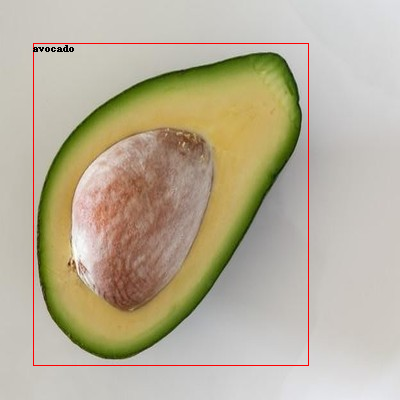

In [57]:
import numpy as np
import os
from PIL import Image, ImageDraw

# Opening JSON file
f = open('data/pics/val/output.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)

image = data["images"][100]
annotations = data["annotations"]
annotations = [x for x in annotations if x['image_id'] == 100]

image = Image.open(os.path.join('data/pics/val', image['file_name']))

draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='black')

image

In [58]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn)
batch = next(iter(train_dataloader))

In [59]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [60]:
pixel_values, target = train_dataset[0]
print(target)

{'boxes': tensor([[0.5913, 0.2113, 0.3125, 0.3175],
        [0.6662, 0.4775, 0.2775, 0.3500],
        [0.4075, 0.6513, 0.2850, 0.3025]]), 'class_labels': tensor([0, 0, 0]), 'image_id': tensor([0]), 'area': tensor([63500., 62160., 55176.]), 'iscrowd': tensor([0, 0, 0]), 'orig_size': tensor([400, 400]), 'size': tensor([800, 800])}


In [61]:
pixel_values.shape

torch.Size([3, 800, 800])

In [62]:
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch

class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", 
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [18]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [63]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([12, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
outputs.logits.shape

torch.Size([1, 100, 12])

In [65]:
from pytorch_lightning import Trainer

trainer = Trainer(gpus=0, max_steps=300, gradient_clip_val=0.1)
trainer.fit(model)

/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.048   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 15/8539 [01:01<9:44:41,  4.12s/it, loss=3.01, v_num=1] 

In [ ]:
! git clone https://github.com/facebookresearch/detr.git
%cd /content/detr